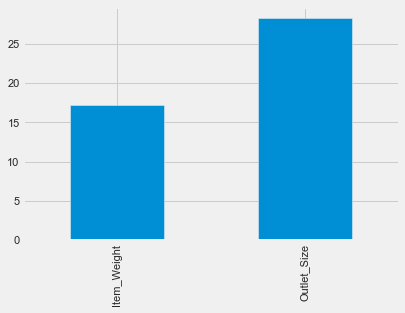

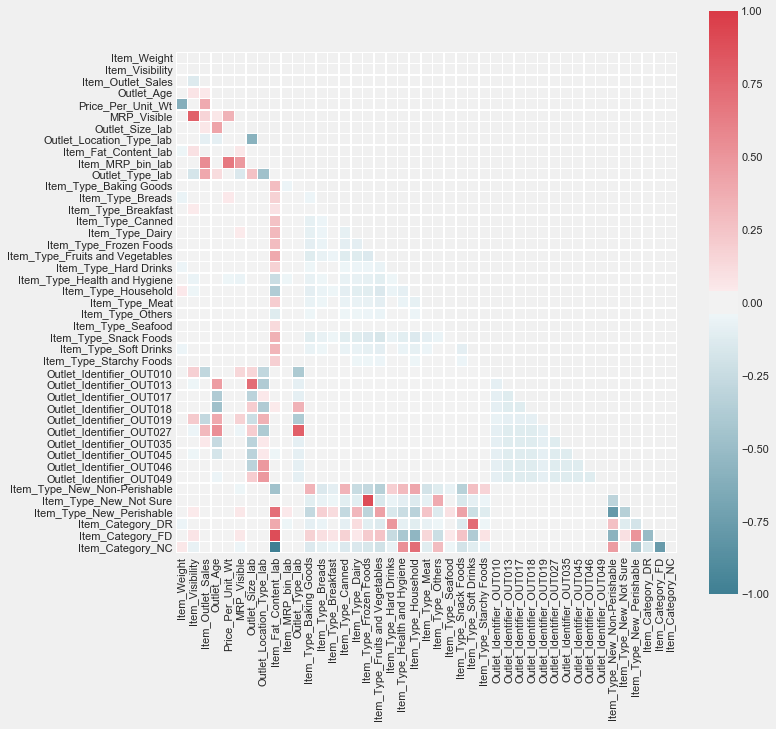

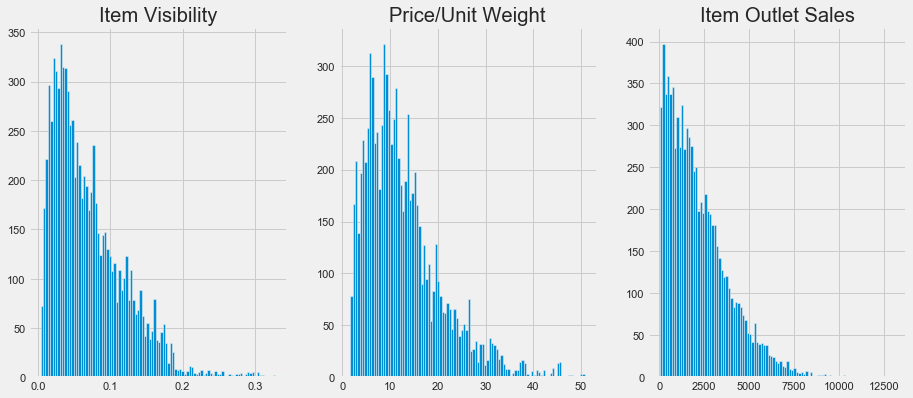

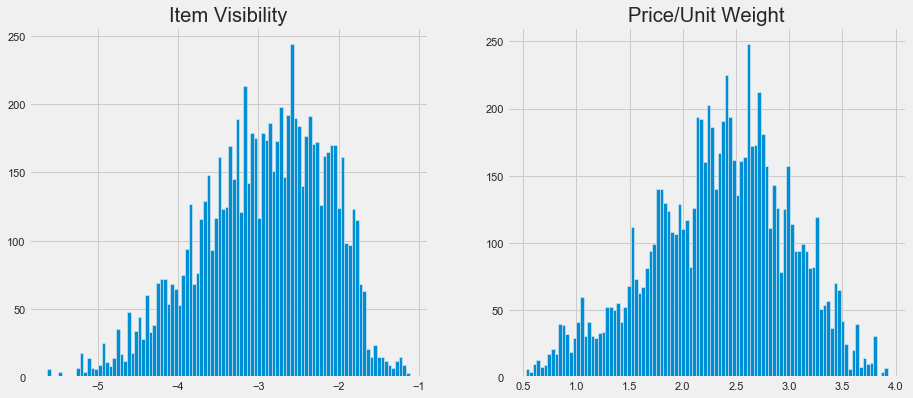

In [2]:
#import primary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')
import scipy
from scipy import stats

train=pd.read_csv('Big_train.csv')
test=pd.read_csv('Big_test.csv')

train_original=train.copy()
test_original=test.copy()

## Imputing Missing Values

missing=train.isnull().sum()
missing=missing[missing>0]*100/len(train)
missing.plot(kind='bar')
plt.show()

# since Item_Identifier is a good indicator for deciding Item_weight, I will impute missing values with avg of weights for specific IDs.
train['Item_Weight']=train['Item_Weight'].fillna(train.groupby(['Item_Identifier'])['Item_Weight'].transform('mean'))
# in order to avoid data leakage I'll do imputation separately
test['Item_Weight']=test['Item_Weight'].fillna(test.groupby(['Item_Identifier'])['Item_Weight'].transform('mean'))
# yet the value for 4 items remained NA, hence I'll impute them again.
train['Item_Weight']=train['Item_Weight'].fillna(train['Item_Weight'].mean())
test['Item_Weight']=test['Item_Weight'].fillna(test['Item_Weight'].mean())

# since Location and tire of a city roughly determines the Outlet_Size, I'll use them to impute missing values
# both codes provide the same result:
train.groupby(['Outlet_Location_Type', 'Outlet_Type'])['Outlet_Size'].agg(pd.Series.mode).reset_index()
#train.groupby(['Outlet_Location_Type', 'Outlet_Type'])['Outlet_Size'].agg(lambda x: x.value_counts().index)

train['Outlet_Size_na']= np.where(train['Outlet_Size'].isnull(), 1, 0)
train.groupby(['Outlet_Location_Type', 'Outlet_Type'])['Outlet_Size_na'].sum().reset_index()

## having both tables we can decide, if the outlet is in tier2 and it is a supermarket type 1 it is most probabely 'small'
## if it's located in tier3 and is a Grocery store it is 'medium'

train.loc[(train['Outlet_Location_Type']== 'Tier 2') & (train['Outlet_Type']== 'Supermarket Type1'), 
                              'Outlet_Size']= 'Small'
train.loc[(train['Outlet_Location_Type']== 'Tier 3') & (train['Outlet_Type']== 'Grocery Store'), 
                              'Outlet_Size']= 'Medium'

test['Outlet_Size_na']= np.where(test['Outlet_Size'].isnull(), 1, 0)
test.groupby(['Outlet_Location_Type', 'Outlet_Type'])['Outlet_Size_na'].sum().reset_index()

test.loc[(test['Outlet_Location_Type']== 'Tier 2') & (test['Outlet_Type']== 'Supermarket Type1'), 
                              'Outlet_Size']= 'Small'
test.loc[(test['Outlet_Location_Type']== 'Tier 3') & (test['Outlet_Type']== 'Grocery Store'), 
                              'Outlet_Size']= 'Medium'

# the other issue is the exsistance of zero value for 526 Items in Item_Visibility feature
# it does not make sense since if an item is not visible, that means no one can buy it, unless the item has been stored in the warehouse
# or the zero value has been entered by mistake
train.Item_Visibility.value_counts()

# to impute zero values with new ones we can use Item_Identifier since, it is highly probable that Items with the same IDs have the same visibility value
train['Item_Visibility']=train['Item_Visibility'].replace(0, train.groupby(['Item_Identifier'])['Item_Visibility'].transform('mean'))
test['Item_Visibility']=test['Item_Visibility'].replace(0, test.groupby(['Item_Identifier'])['Item_Visibility'].transform('mean'))

## Feature Engineering
#### In this section we will create the following new features:

##### Item_Type_new: Broader categories for the variable Item_Type.
##### Item_category: Categorical variable derived from Item_Identifier.
##### Outlet_Years: Years of operation for outlets.
##### price_per_unit_wt: Item_MRP/Item_Weight
##### Item_MRP_clusters: Binned feature for Item_MRP.

#### We can have a look at the Item_Type variable and classify the categories into perishable and non_perishable as per our understanding and make it into a new feature.

train.Item_Type.value_counts()

def perish(x, l1, l2):
    if x in l1:
        return 'Perishable'
    elif x in l2:
        return 'Non-Perishable'
    else:
        return 'Not Sure'

perishable=('Fruits and Vegetables','Snack Foods','Dairy','Meat','Breads','Breakfast','Seafood')
non_perishable=('Household','Frozen Foods ','Canned','Baking Goods','Health and Hygiene','Soft Drinks','Hard Drinks','Starchy Foods')

train['Item_Type_New']= train.Item_Type.apply(lambda x: perish(x, perishable, non_perishable))
test['Item_Type_New']= test.Item_Type.apply(lambda x: perish(x, perishable, non_perishable))

#NC stands for non-consumable
#FD for food & DR for drinks
train['Item_Category']=train.Item_Identifier.apply(lambda x: x[0:2])
test['Item_Category']=test.Item_Identifier.apply(lambda x: x[0:2])

# now we can use Item_Category to rectify Item_Fat_Content since non-consumble products such as houshold does not contain fat
train.loc[train.Item_Category=='NC', 'Item_Fat_Content']='Non-Edible'
test.loc[test.Item_Category=='NC', 'Item_Fat_Content']='Non-Edible'

train['Outlet_Age']=train.Outlet_Establishment_Year.apply(lambda x: 2020-x)
test['Outlet_Age']=test.Outlet_Establishment_Year.apply(lambda x: 2020-x)

train['Price_Per_Unit_Wt']=train.Item_MRP/train.Item_Weight
test['Price_Per_Unit_Wt']=test.Item_MRP/test.Item_Weight

# considering visibility factor in MRP
train['MRP_Visible']=train['Item_MRP']*train['Item_Visibility']
test['MRP_Visible']=test['Item_MRP']*test['Item_Visibility']

bins=[0, 70, 135, 203, 267]
labels=['Low', 'Medium', 'High', 'Very High']

train['Item_MRP_bin']=pd.cut(train['Item_MRP'],  bins=bins, labels=labels)
test['Item_MRP_bin']=pd.cut(test['Item_MRP'],  bins=bins, labels=labels)

## Encoding categorical variables

### Label encoding for ordinal
### One Hot encoding for categorical

def labelencoder1(x):
    if x=='Small':
        return int(1)
    elif x=='Medium':
        return int(2)
    elif x=='High':
        return int(3)
train['Outlet_Size_lab']=train.Outlet_Size.apply(lambda x: labelencoder1(x))
test['Outlet_Size_lab']=test.Outlet_Size.apply(lambda x: labelencoder1(x))
train.Outlet_Size_lab.value_counts(), train.Outlet_Size.value_counts()

def labelencoder2(x):
    if x=='Tier 3':
        return int(1)
    elif x=='Tier 2':
        return int(2)
    elif x=='Tier 1':
        return int(3)
train['Outlet_Location_Type_lab']=train.Outlet_Location_Type.apply(lambda x: labelencoder2(x))
test['Outlet_Location_Type_lab']=test.Outlet_Location_Type.apply(lambda x: labelencoder2(x))
train.Outlet_Location_Type.value_counts(), train.Outlet_Location_Type_lab.value_counts()

def labelencoder3(x):
    if x=='Non-Edible':
        return int(1)
    elif x=='LF':
        return int(2)
    elif x=='Reg':
        return int(3)
    
train['Item_Fat_Content_lab']=train.Item_Fat_Content.apply(lambda x: labelencoder3(x))
test['Item_Fat_Content_lab']=test.Item_Fat_Content.apply(lambda x: labelencoder3(x))
train.Item_Fat_Content_lab.value_counts(), train.Item_Fat_Content.value_counts()

def labelencoder4(x):
    if x== 'Low':
        return int(1)
    elif x== 'Medium':
        return int(2)
    elif x== 'High':
        return int(3)
    else:
        return int(4)
train['Item_MRP_bin_lab']=train['Item_MRP_bin'].apply(lambda x: labelencoder4(x))
test['Item_MRP_bin_lab']=test['Item_MRP_bin'].apply(lambda x: labelencoder4(x))
train['Item_MRP_bin'].value_counts(), train['Item_MRP_bin_lab'].value_counts()

def labelencoder5(x):
    if x== 'Grocery Store':
        return int(1)
    elif x== 'Supermarket Type1':
        return int(2)
    elif x== 'Supermarket Type2':
        return int(3)
    else:
        return int(4)
train['Outlet_Type_lab']=train['Outlet_Type'].apply(lambda x: labelencoder5(x))
test['Outlet_Type_lab']=test['Outlet_Type'].apply(lambda x: labelencoder5(x))
train['Outlet_Type'].value_counts(), train['Outlet_Type_lab'].value_counts()

train.drop(columns=['Outlet_Location_Type','Outlet_Size', 'Item_Fat_Content', 'Item_MRP', 'Outlet_Size_na',
                   'Item_Identifier', 'Outlet_Establishment_Year', 'Outlet_Type', 'Item_MRP_bin'], inplace=True)
test.drop(columns=['Outlet_Location_Type','Outlet_Size', 'Item_Fat_Content', 'Item_MRP', 'Outlet_Size_na',
                   'Item_Identifier', 'Outlet_Establishment_Year', 'Outlet_Type', 'Item_MRP_bin'], inplace=True)

dummy_cols=[f for f in train.columns if train[f].dtype=='O']
ohe_train=pd.get_dummies(train[dummy_cols])
ohe_test=pd.get_dummies(test[dummy_cols])


ohe_test.shape, ohe_train.shape, train.shape

train.drop(dummy_cols,axis=1, inplace=True)
train=pd.concat([train, ohe_train], axis=1)

test.drop(dummy_cols, axis=1, inplace=True)
test=pd.concat([test, ohe_test], axis=1)
train.shape, test.shape

train.head()

## Feature Selection
#### in order to avoid multicollinearity we should drop highly correlated columns or diminish the influence of them through application of lasso regression

train['Item_MRP_bin_lab']=train['Item_MRP_bin_lab'].astype('int64')

plt.figure(1, figsize=(10,10))
corr_matrix=train.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix,mask=mask, 
            square=True, linewidths=.5, annot=False, cmap=cmap)
plt.show()

train.drop(['MRP_Visible', 'Item_Weight'], axis=1, inplace=True)
test.drop(['MRP_Visible', 'Item_Weight'], axis=1, inplace=True)

## preprocessing
### removing skewness

train.head()

fig, ax=plt.subplots(1,figsize=(14,6))
plt.subplot(131)
plt.title('Item Visibility')
train.Item_Visibility.hist(bins=100)
plt.subplot(132)
plt.title('Price/Unit Weight')
train.Price_Per_Unit_Wt.hist(bins=100)
plt.subplot(133)
plt.title('Item Outlet Sales')
train.Item_Outlet_Sales.hist(bins=100) #it's the target variable we shouldn't change it.
plt.show()

#Since data is positively skewed, the best practice is to remove skewness through log which penalize higher values
train.Item_Visibility=np.log(train.Item_Visibility)
test.Item_Visibility=np.log1p(test.Item_Visibility)
train.Price_Per_Unit_Wt=np.log(train.Price_Per_Unit_Wt)
test.Price_Per_Unit_Wt=np.log(test.Price_Per_Unit_Wt)

fig, ax=plt.subplots(1,figsize=(14,6))
plt.subplot(121)
plt.title('Item Visibility')
train.Item_Visibility.hist(bins=100)
plt.subplot(122)
plt.title('Price/Unit Weight')
train.Price_Per_Unit_Wt.hist(bins=100)
plt.show()

## Normalization

X_train=train.loc[:, train.columns!='Item_Outlet_Sales']
y=train['Item_Outlet_Sales']

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Since we have negative values for Item_Visibility, first, I will standardize values and then normalize them. 
st_scaler=StandardScaler()
norm_scaler_1=MinMaxScaler()
train_vis=(train['Item_Visibility'].values).reshape(-1,1)
train_vis_st=((pd.DataFrame(st_scaler.fit_transform(train_vis))).values).reshape(-1,1)
train_vis_norm=pd.DataFrame(norm_scaler_1.fit_transform(train_vis_st), columns=['Item_Visibility'])

test_vis=(test['Item_Visibility'].values).reshape(-1,1)
test_vis_st=((pd.DataFrame(st_scaler.transform(test_vis))).values).reshape(-1,1)
test_vis_norm=pd.DataFrame(norm_scaler_1.transform(test_vis_st), columns=['Item_Visibility'])

# now we can normalize the rest of numerical predictors
norm_scaler_2=MinMaxScaler()
train_num=X_train.iloc[:,1:8].values
test_num=test.iloc[:, 1:8].values
train_num_norm=pd.DataFrame(norm_scaler_2.fit_transform(train_num), columns=X_train.iloc[:,1:8].columns)
test_num_norm=pd.DataFrame(norm_scaler_2.transform(test_num), columns=test.iloc[:, 1:8].columns)

# Finally it's time to normalize target variabe
norm_scaler_3=MinMaxScaler()
target=y.values.reshape(-1,1)
target_norm=pd.DataFrame(norm_scaler_3.fit_transform(target), columns=['Item_Outlet_Sales'])

# now we should concate all dataframes.
train=pd.concat([train_vis_norm, train_num_norm,X_train.iloc[:, 8:], target_norm ], axis=1)
test=pd.concat([test_vis_norm, test_num_norm, test.iloc[:, 8:]], axis=1)